In [1]:
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pickle
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from imblearn.combine import SMOTETomek
scaler=StandardScaler()
sm = SMOTETomek(random_state = 42)
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## 1. Import and understand the data.

### A. Import ‘signal-data.csv’ as DataFrame.

In [2]:
signal_data=pd.read_csv('signal-data.csv')
signal_data.shape

(1567, 592)

signal_data dataset contains 1567 data entries and 592 features.

In [3]:
signal_data.sample(n=5, random_state=42)

Time        0        1          2          3       4  \
548  2008-08-29 22:45:00  2929.60  2564.91  2216.4778  1242.2350  0.8379   
664  2008-02-09 06:32:00  2979.45  2546.78  2217.8111  1744.7771  0.9618   
730  2008-04-09 16:30:00  3136.34  2442.45  2250.7445   996.4071  0.8572   
405  2008-08-22 05:32:00  3052.97  2501.63  2218.0555  1517.4371  0.8579   
175  2008-09-08 22:37:00  3071.09  2521.23  2248.4222  1418.5634  1.4905   

         5         6       7       8  ...      581     582     583     584  \
548  100.0  105.1111  0.1233  1.5190  ...  41.3226  0.4952  0.0120  0.0031   
664  100.0  100.1789  0.1218  1.4786  ...      NaN  0.5040  0.0115  0.0026   
730  100.0  106.2956  0.1172  1.4285  ...  25.1494  0.5022  0.0173  0.0040   
405  100.0  105.8133  0.1206  1.4732  ...      NaN  0.5010  0.0108  0.0028   
175  100.0  102.6444  0.1212  1.6138  ...      NaN  0.4974  0.0130  0.0035   

        585     586     587     588       589  Pass/Fail  
548  2.4192  0.0354  0.0146  0.0049   41.3226         -1  
664  2.2880  0.0263  0.0117  0.0033   44.3686         -1  
730  3.4516  0.0335  0.0084  0.0030   25.1494         -1  
405  2.1487  0.0061  0.0141  0.0046  233.2441         -1  
175  2.6058  0.0254  0.0160  0.0051   62.9443         -1  

[5 rows x 592 columns]

In [4]:
signal_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 592 entries, Time to Pass/Fail
dtypes: float64(590), int64(1), object(1)
memory usage: 7.1+ MB


In [5]:
# Time feature to time dtype
signal_data['Time']=pd.to_datetime(signal_data['Time'])
signal_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 592 entries, Time to Pass/Fail
dtypes: datetime64[ns](1), float64(590), int64(1)
memory usage: 7.1 MB


In this dataset there are 592 features as numerical dtype with float64(590) and int64(1) and 1 feature as datetime i.e. 'Time'

As checking Pass/Fail feature, its having 1 & -1 as value, so will convert -1 to 0(PASS) and 1(FAIL) as it.

In [6]:
signal_data['Pass/Fail']=signal_data['Pass/Fail'].replace(-1,0)
signal_data['Pass/Fail'].value_counts()

0    1463
1     104
Name: Pass/Fail, dtype: int64

### B. Print 5 point summary and share at least 2 observations.

In [7]:
signal_data.describe()

0            1            2            3            4  \
count  1561.000000  1560.000000  1553.000000  1553.000000  1553.000000   
mean   3014.452896  2495.850231  2200.547318  1396.376627     4.197013   
std      73.621787    80.407705    29.513152   441.691640    56.355540   
min    2743.240000  2158.750000  2060.660000     0.000000     0.681500   
25%    2966.260000  2452.247500  2181.044400  1081.875800     1.017700   
50%    3011.490000  2499.405000  2201.066700  1285.214400     1.316800   
75%    3056.650000  2538.822500  2218.055500  1591.223500     1.525700   
max    3356.350000  2846.440000  2315.266700  3715.041700  1114.536600   

            5            6            7            8            9  ...  \
count  1553.0  1553.000000  1558.000000  1565.000000  1565.000000  ...   
mean    100.0   101.112908     0.121822     1.462862    -0.000841  ...   
std       0.0     6.237214     0.008961     0.073897     0.015116  ...   
min     100.0    82.131100     0.000000     1.191000    -0.053400  ...   
25%     100.0    97.920000     0.121100     1.411200    -0.010800  ...   
50%     100.0   101.512200     0.122400     1.461600    -0.001300  ...   
75%     100.0   104.586700     0.123800     1.516900     0.008400  ...   
max     100.0   129.252200     0.128600     1.656400     0.074900  ...   

              581          582          583          584          585  \
count  618.000000  1566.000000  1566.000000  1566.000000  1566.000000   
mean    97.934373     0.500096     0.015318     0.003847     3.067826   
std     87.520966     0.003404     0.017180     0.003720     3.578033   
min      0.000000     0.477800     0.006000     0.001700     1.197500   
25%     46.184900     0.497900     0.011600     0.003100     2.306500   
50%     72.288900     0.500200     0.013800     0.003600     2.757650   
75%    116.539150     0.502375     0.016500     0.004100     3.295175   
max    737.304800     0.509800     0.476600     0.104500    99.303200   

               586          587          588          589    Pass/Fail  
count  1566.000000  1566.000000  1566.000000  1566.000000  1567.000000  
mean      0.021458     0.016475     0.005283    99.670066     0.066369  
std       0.012358     0.008808     0.002867    93.891919     0.249005  
min      -0.016900     0.003200     0.001000     0.000000     0.000000  
25%       0.013425     0.010600     0.003300    44.368600     0.000000  
50%       0.020500     0.014800     0.004600    71.900500     0.000000  
75%       0.027600     0.020300     0.006400   114.749700     0.000000  
max       0.102800     0.079900     0.028600   737.304800     1.000000  

[8 rows x 591 columns]

Observations:
1. In most of the features there are some missing values, which needs to be imputed or drop.
2. Outliers are present in many features like, '4', '15' and more.
3. There are some features having same values throughout the dataset like, '5', '13' and more.

## Data cleansing

### A. Write a for loop which will remove all the features with 20%+ Null values and impute rest with mean of the feature.

In [8]:
empty_col_more_than_20=signal_data.columns[signal_data.isnull().mean()>0.20]
empty_col_more_than_20.size

32

There are 32 features which are having more than 20% of null values. These features we can remove.

In [9]:
# Copying original data data to different variable
signal_data_original=signal_data.copy(deep=True)

for col in signal_data.columns.drop(['Pass/Fail','Time']):
    # Removing features having more than 20% null values
    if signal_data[col].isnull().mean()>0.20:
        signal_data.drop(col,axis=1,inplace=True)
    # Imputing NaN values with mean
    else:
        signal_data[col].fillna(signal_data[col].mean(),inplace=True)

In [10]:
signal_data.shape

(1567, 560)

In [11]:
signal_data.isnull().any().unique()

array([False])

After removal of 32 features and imputation of null values, we have 560 features left with missing datas.

### B. Identify and drop the features which are having same value for all the rows.

In [12]:
signal_data.columns[signal_data.nunique()==1]

Index(['5', '13', '42', '49', '52', '69', '97', '141', '149', '178',
       ...
       '529', '530', '531', '532', '533', '534', '535', '536', '537', '538'],
      dtype='object', length=116)

There are 116 features having same value throughout the dataset, which won't be relevant for our further analysis.

In [13]:
signal_data.drop(columns=signal_data.columns[signal_data.nunique()==1],axis=1,inplace=True)
signal_data.shape

(1567, 444)

### C. Drop other features if required using relevant functional knowledge. Clearly justify the same.
### D. Check for multi-collinearity in the data and take necessary action.
### E. Make all relevant modifications on the data using both functional/logical reasoning/assumptions.

Removing outliers from dataset

In [14]:
def outlier_check(df1):

    column_names=df1.columns

    for col_name in column_names:
        q1=np.quantile(df1[col_name], 0.25)
        q3=np.quantile(df1[col_name], 0.75)
        cut_off=1.5*(q3-q1)
        right_whisker= q3 + cut_off
        left_whiskers=q1 - cut_off

        #Replace every outlier on the upper side by the upper whisker
        for i in np.where(df1[col_name] > right_whisker)[0]:
            df1.loc[i,col_name] = right_whisker

        #Replace every outlier on the lower side by the lower whisker
        for i in np.where(df1[col_name] < left_whiskers)[0]:
            df1.loc[i,col_name] = left_whiskers

    return df1
signal_data=pd.concat([outlier_check(signal_data.drop(columns=['Pass/Fail','Time'])),signal_data[['Time','Pass/Fail']]],axis=1)

In [15]:
# re-iterating duplication removal after outlier check
signal_data.drop(columns=signal_data.columns[signal_data.nunique()==1],axis=1,inplace=True)

Using correlation matrix, will remove those matrix having correlation more than 85% both side.

In [16]:
signal_data_scaled = scaler.fit_transform(signal_data.drop(columns=['Time','Pass/Fail']))
signal_data_scaled = pd.DataFrame(signal_data_scaled,columns=signal_data.columns.drop(['Time','Pass/Fail']))
signal_data_scaled=pd.concat([signal_data_scaled,signal_data[['Time','Pass/Fail']]],axis=1)
signal_data_scaled.shape

(1567, 434)

In [17]:
lower_corr=signal_data_scaled.corr().where(np.tril(np.ones(signal_data_scaled.corr().shape), k=-1).astype(bool))

# Find features with correlation greater than 0.85
negative_relation = [column for column in lower_corr.columns if any(lower_corr[column] < -0.85)]
positive_relation = [column for column in lower_corr.columns if any(lower_corr[column] > 0.85)]

len(positive_relation+negative_relation)

201

Dropping 201 which are having more than 85% correlation.

In [18]:
signal_data_scaled.drop(columns=positive_relation+negative_relation, axis=1, inplace=True)
signal_data_scaled.shape

(1567, 233)

Checking multi-collinearity using VIF(Variance Inflation Factor), i.e.
$$
VIF=\frac{1}{1-R^2}
$$

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = signal_data_scaled.columns.drop(['Pass/Fail','Time'])

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(signal_data_scaled[vif_data["feature"]].values, i) for i in range(len(vif_data["feature"]))]

print(len(vif_data[vif_data.VIF<5]))

190


Using VIF, in stated that only 190 features are having VIF score less than 5, that can be used by model.

Using PCA

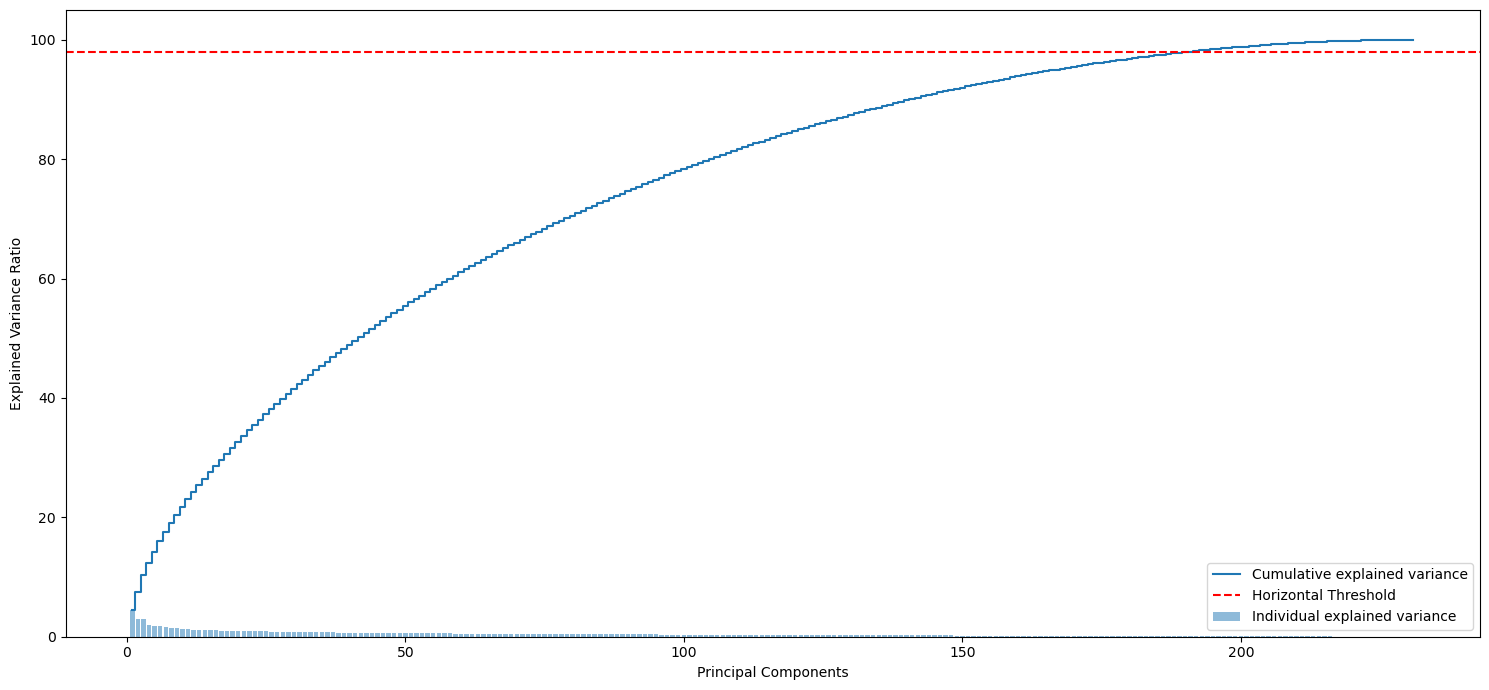

In [20]:
# Step 1 - Create covariance matrix
cov_matrix = np.cov(signal_data_scaled.drop(columns=['Pass/Fail','Time']).T)

# Step 2- Get eigen values and eigen vector
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

# Step 3- Find variance and cumulative variance by each eigen vector
tot = sum(eig_vals)
var_exp = [( i /tot ) * 100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

# Ploting
plt.figure(figsize=(15 , 7))
plt.bar(range(1, eig_vals.size + 1), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.step(range(1, eig_vals.size + 1), cum_var_exp, where='mid', label = 'Cumulative explained variance')
plt.axhline(98, c='r', linestyle = 'dashed', label = "Horizontal Threshold")
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

Using PCA, taking 98% of variance gives n_components as approx 190 for model training.

So from above analysis, it's being interpreted that we can remove some features which are not required for our model.
Currently, we will use VIF method for dimension reduction.

In [21]:
signal_data_scaled.drop(columns=vif_data[vif_data.VIF>5]['feature'],axis=1,inplace=True)
signal_data_scaled.shape

(1567, 192)

After removing unwanted features, dataset have 202 features that will be used for further analysis.

Summary of data modification:
- Removed all features having more than 20% of null values and other NaN has been updated with mean value
- Some features were having constant value throughout the dataset, so these values has been removed as these are some discrepancy data or we can say it won't be helpful with our modelling.
- As features were having outliers, so data being imputed using IQR technique.
- Features having more than 85% of correlation have been removed as these features were strongly correlated.
- As dataset has multi-collinearity, so it has been treated using VIF(Variance Inflation Factor).

## 3. Data analysis & visualisation

### A. Perform a detailed univariate Analysis with appropriate detailed comments after each analysis.
### B. Perform bivariate and multivariate analysis with appropriate detailed comments after each analysis.

#### Uni-variate Analysis:

In [22]:
signal_data_scaled['Pass/Fail'].value_counts()

0    1463
1     104
Name: Pass/Fail, dtype: int64

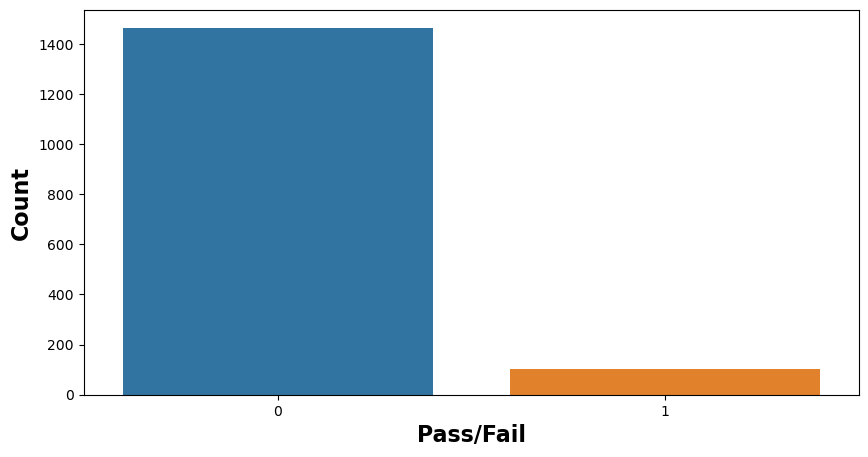

In [23]:
plt.figure(figsize=(10,5))
sns.countplot(data=signal_data_scaled, x='Pass/Fail')
plt.xlabel('Pass/Fail', weight='bold', fontsize=16)
plt.ylabel('Count', weight='bold', fontsize=16)
plt.show()

Describing above graphical representation
- Pass category has value as 0(-1) and contains 1463 data.
- Fail category has value as 1 and contains 104 data.

In [24]:
fig=px.pie(signal_data_scaled, hole=0.3, values=signal_data_scaled['Time'].dt.month.value_counts(), names=[calendar.month_name[ind] for ind in signal_data_scaled['Time'].dt.month.value_counts().index], color_discrete_sequence=px.colors.sequential.deep_r, title='Monthly Representation')
fig.show();

In [25]:
print('Dataset contains 2008 year data which has been distributed as below:')
print("\n".join(["{key} contains {val} data.".format(key=calendar.month_name[key], val = val) for key,val in sorted(dict(signal_data_scaled['Time'].dt.month.value_counts()).items())]))

Dataset contains 2008 year data which has been distributed as below:
January contains 51 data.
February contains 98 data.
March contains 50 data.
April contains 49 data.
May contains 62 data.
June contains 67 data.
July contains 114 data.
August contains 471 data.
September contains 413 data.
October contains 123 data.
November contains 35 data.
December contains 34 data.


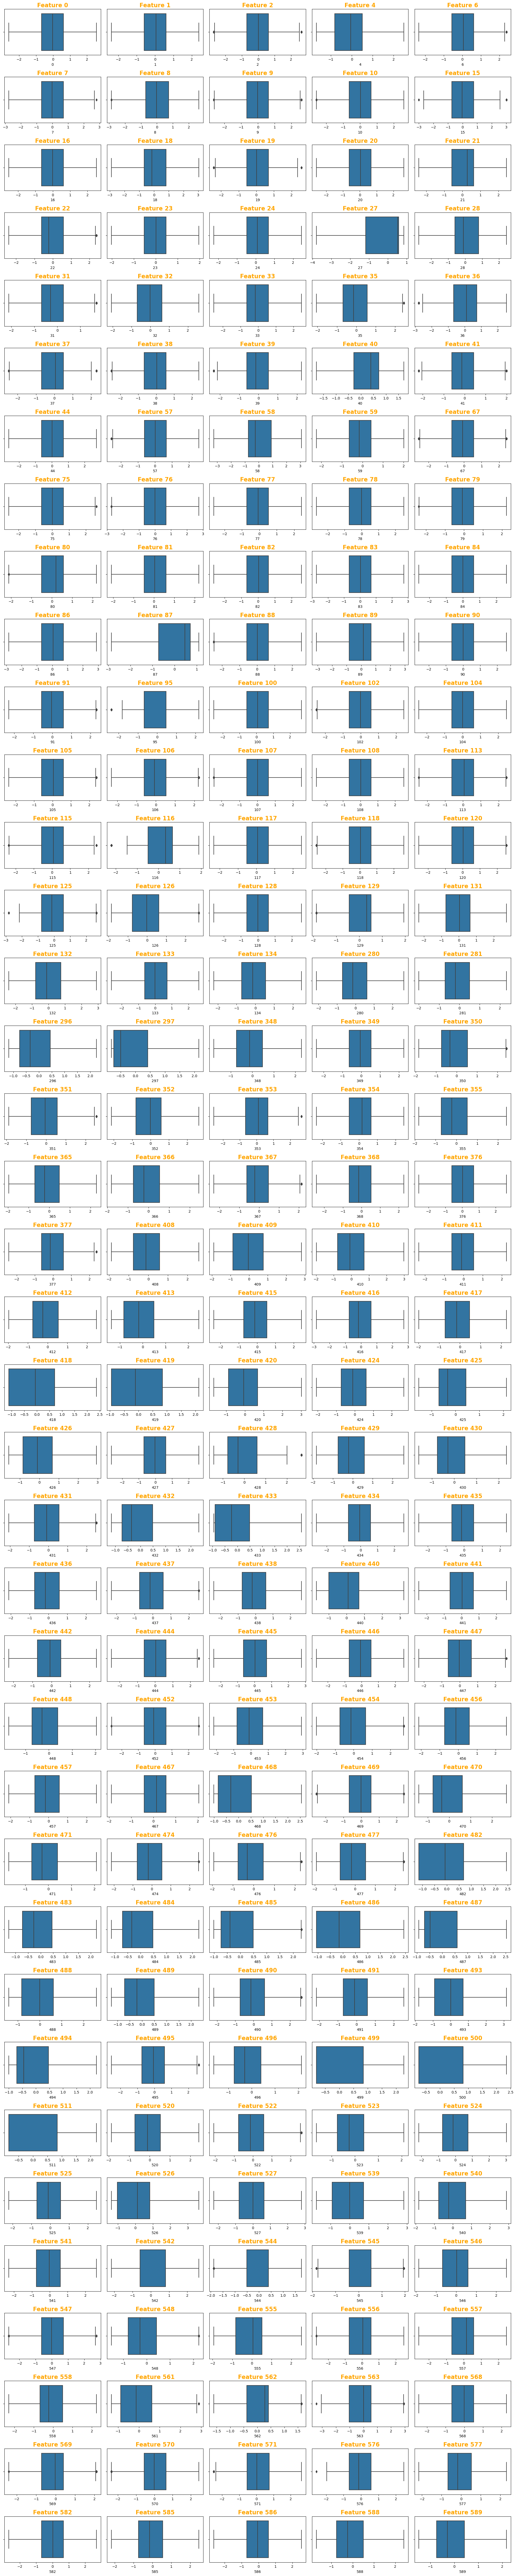

In [26]:
columns=signal_data_scaled.columns.drop(['Pass/Fail','Time'])
fig=plt.figure(figsize=(20,100))
for i in range(0,len(columns)):
   ax=fig.add_subplot(38,5,i+1)
   sns.boxplot(signal_data_scaled[columns[i]])
   ax.set_title('Feature '+columns[i],color='orange',weight='bold',fontsize=16)
plt.tight_layout()
plt.show()

In above diagram, we can see most of the features are scaled and aren't having any outliers. Few features still contains some outliers.

#### Bi-variate Analysis

<Figure size 1500x700 with 0 Axes>

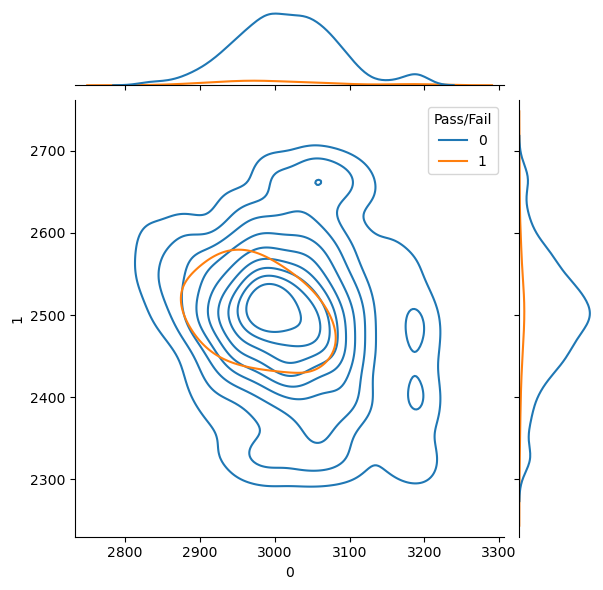

In [27]:
plt.figure(figsize=(15,7))
sns.jointplot(data=signal_data, x='0',y='1',hue='Pass/Fail',kind='kde')
plt.show();

<Figure size 1500x700 with 0 Axes>

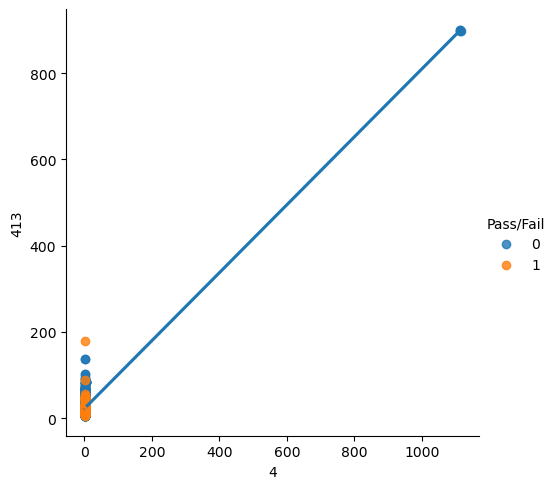

In [28]:
plt.figure(figsize=(15,7))
sns.lmplot(data=signal_data_original, x='4',y='413', hue='Pass/Fail')
plt.show();

Above graphical representation stated that feature '4' and '413' are highly positively correlated.

<Figure size 1500x700 with 0 Axes>

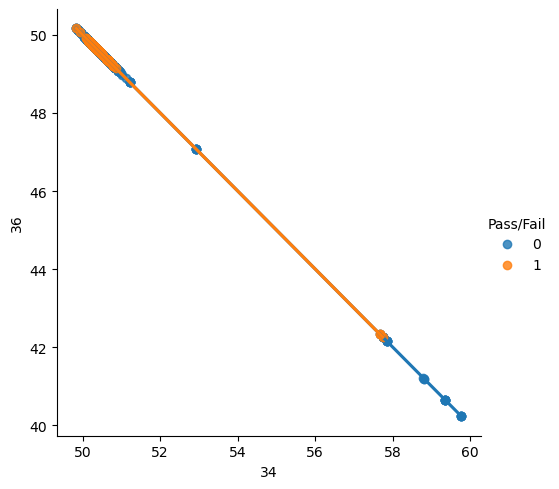

In [29]:
plt.figure(figsize=(15,7))
sns.lmplot(data=signal_data_original, x='34',y='36', hue='Pass/Fail')
plt.show();

Above graphical representation stated that feature '34' and '36' are highly negatively correlated.

#### Multi-variate Analysis

Let's see pair-plot for random 10 features.

<Figure size 1500x700 with 0 Axes>

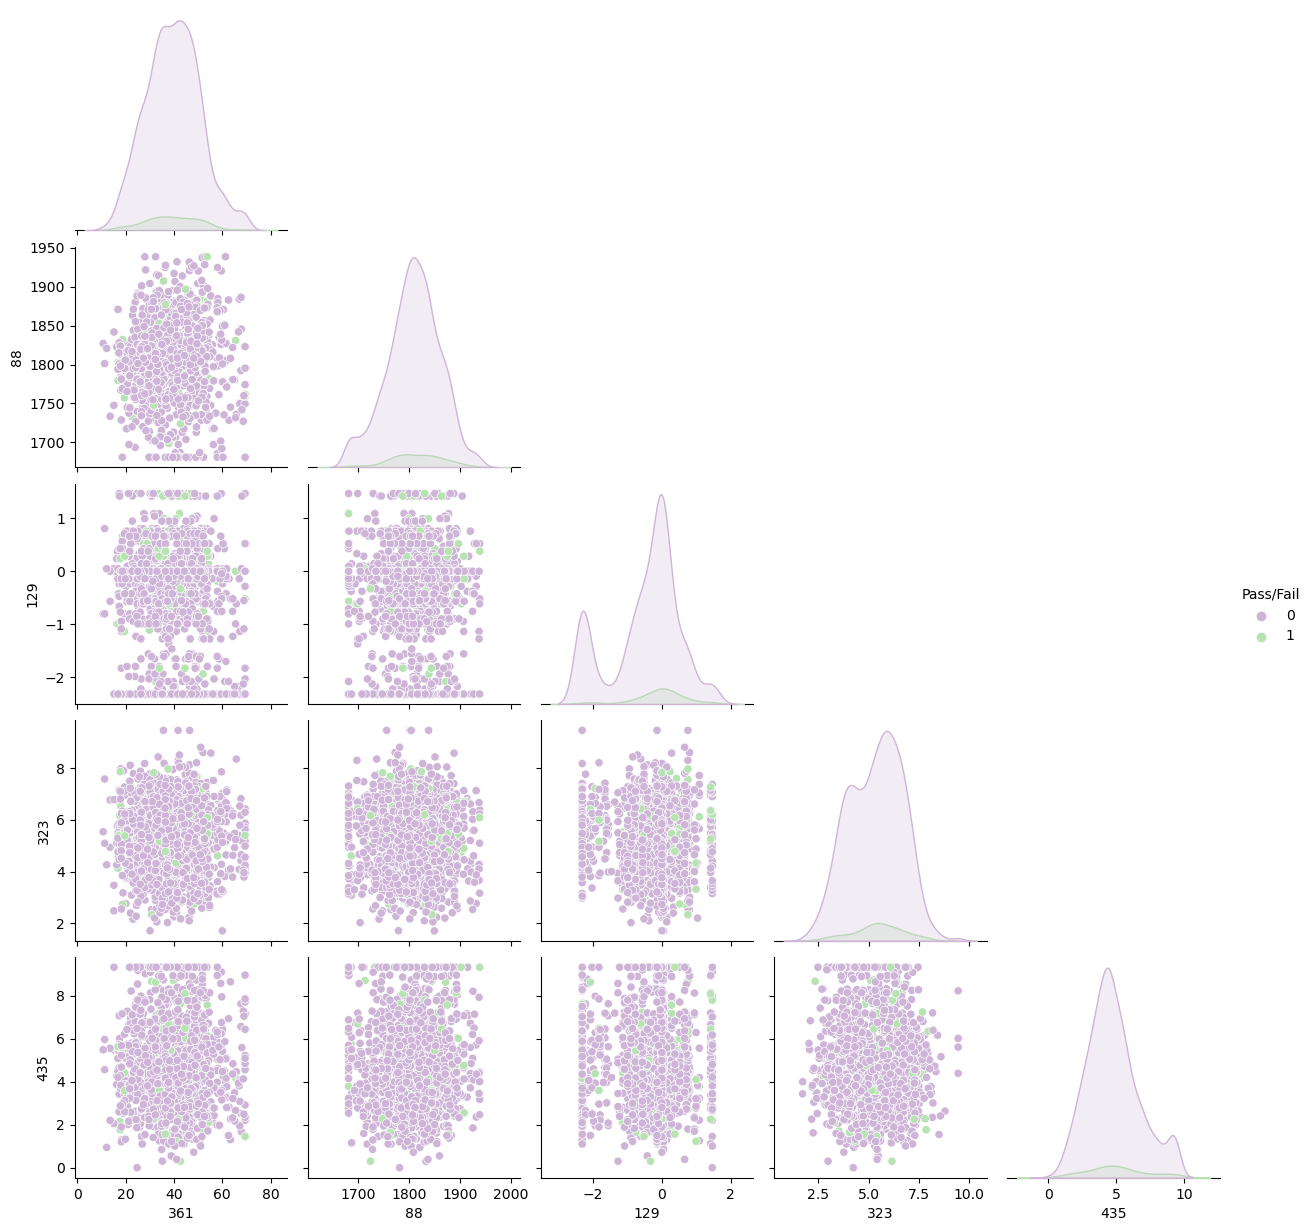

In [30]:
# Random feature pair-plot representation
np.random.seed(42)
random_5_columns=np.random.choice(signal_data.columns, size=5,replace=False)
plt.figure(figsize=(15,7))
sns.pairplot(data=signal_data, vars=random_5_columns, hue='Pass/Fail', corner=True, palette='PRGn')
plt.show();

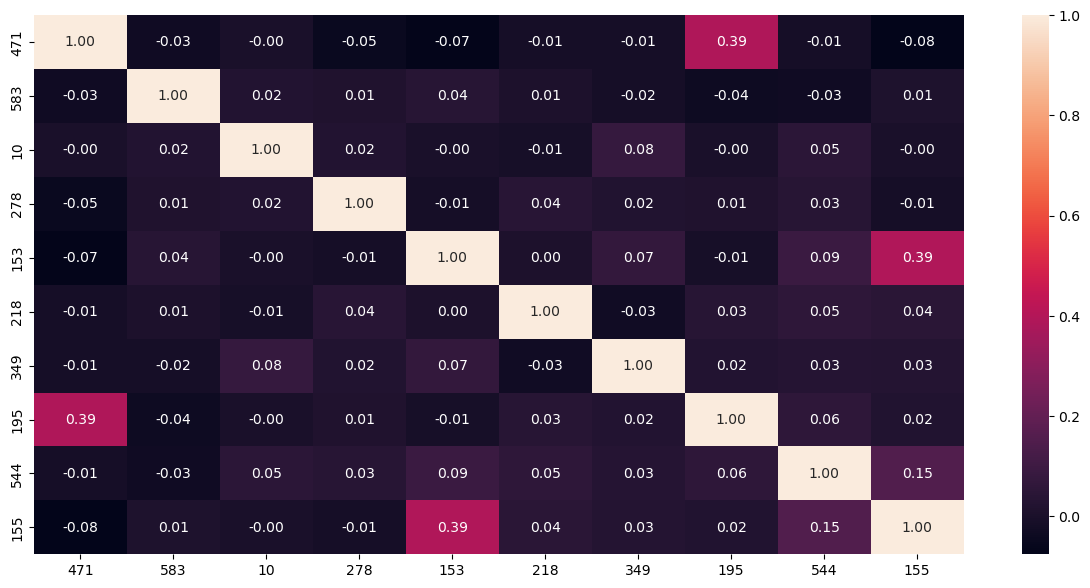

In [31]:
# Random feature heatmap representation
np.random.seed(40)
random_10_columns=np.random.choice(signal_data.columns, size=10,replace=False)
plt.figure(figsize=(15,7))
sns.heatmap(signal_data[random_10_columns].corr(), fmt='.2f',annot=True)
plt.show();

In [32]:
print('Total ' + str(len(positive_relation+negative_relation)) + ' features are present which are having more than 85% of correlation')

Total 201 features are present which are having more than 85% of correlation


## 4. Data pre-processing

### A. Segregate predictors vs target attributes.
### B. Check for target balancing and fix it if found imbalanced.

In [33]:
predictors=signal_data_scaled.drop(columns=['Time','Pass/Fail'],axis=1)
target=signal_data_scaled['Pass/Fail']

In [34]:
predictors.shape, target.shape

((1567, 190), (1567,))

In [35]:
target.value_counts()

0    1463
1     104
Name: Pass/Fail, dtype: int64

As checked target feature isn't balanced properly, so will use SMOTE technique to balance it.

In [36]:
X,y=sm.fit_resample(predictors, target)
X.shape, y.shape

((2926, 190), (2926,))

In [37]:
y.value_counts()

0    1463
1    1463
Name: Pass/Fail, dtype: int64

Up-sampling has been done and now data can be used for model training.

### C. Perform train-test split and standardise the data or vice versa if required.

As data has been already standardised using StandardScaler(), so we will continue with splitting of data into train and test

In [38]:
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.20, random_state=42)
X_train.shape, X_test.shape

((2340, 190), (586, 190))

### D. Check if the train and test data have similar statistical characteristics when compared with original data.

5-point summary for X_train, X_test and original data.

In [39]:
X_train.describe()

0            1            2            4            6  \
count  2340.000000  2340.000000  2340.000000  2340.000000  2340.000000   
mean     -0.071202    -0.069589    -0.056531    -0.057842     0.015695   
std       0.982886     0.876817     0.931074     0.901693     0.847308   
min      -2.607020    -2.384880    -2.709208    -1.693017    -2.338436   
25%      -0.759389    -0.587598    -0.758029    -0.742420    -0.399866   
50%      -0.162718    -0.031245    -0.110441    -0.100720     0.051136   
75%       0.507763     0.435396     0.543960     0.431168     0.512414   
max       2.551114     2.384542     2.625456     2.491520     2.377008   

                 7            8            9           10           15  ...  \
count  2340.000000  2340.000000  2340.000000  2340.000000  2340.000000  ...   
mean     -0.064112     0.018457    -0.113852     0.022354     0.013868  ...   
std       0.891944     0.860270     0.900096     0.954882     0.878981  ...   
min      -2.770572    -2.859293    -2.630367    -2.584708    -2.678021  ...   
25%      -0.629684    -0.556181    -0.657206    -0.548410    -0.603693  ...   
50%      -0.122260     0.007581    -0.126494     0.097615    -0.031524  ...   
75%       0.556833     0.584478     0.411199     0.627417     0.608254  ...   
max       2.800897     2.598180     2.595108     2.592603     3.006266  ...   

               569          570          571          576          577  \
count  2340.000000  2340.000000  2340.000000  2340.000000  2340.000000   
mean      0.047312     0.036947     0.031680    -0.059795    -0.049912   
std       0.926761     0.896497     0.990249     0.928203     0.940399   
min      -2.411187    -2.354902    -2.477746    -2.562470    -2.155395   
25%      -0.719466    -0.443255    -0.512920    -0.697646    -0.671743   
50%       0.110807     0.019110     0.129414    -0.144716    -0.198341   
75%       0.481436     0.622844     0.742122     0.497663     0.436239   
max       2.100069     2.437555     2.619318     2.460448     2.307370   

               582          585          586          588          589  
count  2340.000000  2340.000000  2340.000000  2340.000000  2340.000000  
mean      0.095666     0.050371    -0.006578     0.042006     0.025156  
std       0.986122     0.934018     0.909743     0.909619     0.906130  
min      -2.672854    -2.179762    -2.640309    -1.705644    -1.474090  
25%      -0.522554    -0.623480    -0.626134    -0.641463    -0.639667  
50%       0.117122    -0.041732    -0.067651    -0.068443    -0.206631  
75%       0.727588     0.541770     0.583341     0.545495     0.448171  
max       2.681494     2.459509     2.532152     2.407823     2.171000  

[8 rows x 190 columns]

In [40]:
X_test.describe()

0           1           2           4           6           7  \
count  586.000000  586.000000  586.000000  586.000000  586.000000  586.000000   
mean    -0.098211   -0.055774   -0.134199   -0.077545   -0.027417   -0.022360   
std      0.979983    0.916749    0.900046    0.860151    0.832985    0.867868   
min     -2.607020   -2.384880   -2.709208   -1.550075   -2.338436   -2.770572   
25%     -0.764158   -0.579298   -0.841032   -0.752736   -0.427750   -0.622385   
50%     -0.217363    0.000321   -0.171791   -0.094469    0.003889   -0.113807   
75%      0.419496    0.473697    0.469797    0.423294    0.401448    0.556833   
max      2.551114    2.384542    2.625456    2.491520    2.377008    2.671928   

                8           9          10          15  ...         569  \
count  586.000000  586.000000  586.000000  586.000000  ...  586.000000   
mean     0.025583   -0.115550    0.049243    0.000777  ...    0.033378   
std      0.888236    0.932843    0.963727    0.907361  ...    0.962053   
min     -2.859293   -2.630367   -2.584708   -2.998354  ...   -2.411187   
25%     -0.583021   -0.688439   -0.553176   -0.582375  ...   -0.719466   
50%     -0.010115   -0.112886    0.077105   -0.026162  ...    0.083183   
75%      0.631830    0.490675    0.628601    0.552738  ...    0.512273   
max      2.632200    2.595108    2.592603    3.006266  ...    2.100069   

              570         571         576         577         582         585  \
count  586.000000  586.000000  586.000000  586.000000  586.000000  586.000000   
mean     0.039546   -0.031330   -0.118291   -0.029595    0.059455   -0.014327   
std      0.906570    1.053891    0.946419    0.947786    0.958324    0.887309   
min     -2.354902   -2.477746   -1.975823   -2.011176   -2.672854   -1.893770   
25%     -0.466504   -0.584153   -0.792103   -0.629663   -0.572677   -0.681770   
50%      0.034255    0.118117   -0.184581   -0.232405    0.056660   -0.118803   
75%      0.640384    0.761770    0.486575    0.526045    0.722589    0.491747   
max      2.437555    2.351960    2.460448    2.307370    2.613812    2.459509   

              586         588         589  
count  586.000000  586.000000  586.000000  
mean    -0.026238    0.020305    0.047767  
std      0.936543    0.899494    0.952674  
min     -2.478098   -1.623784   -1.474090  
25%     -0.676186   -0.641463   -0.668725  
50%     -0.028947   -0.140701   -0.234535  
75%      0.574202    0.503345    0.455019  
max      2.532152    2.407823    2.171000  

[8 rows x 190 columns]

In [41]:
signal_data_original.describe()

0            1            2            3            4  \
count  1561.000000  1560.000000  1553.000000  1553.000000  1553.000000   
mean   3014.452896  2495.850231  2200.547318  1396.376627     4.197013   
std      73.621787    80.407705    29.513152   441.691640    56.355540   
min    2743.240000  2158.750000  2060.660000     0.000000     0.681500   
25%    2966.260000  2452.247500  2181.044400  1081.875800     1.017700   
50%    3011.490000  2499.405000  2201.066700  1285.214400     1.316800   
75%    3056.650000  2538.822500  2218.055500  1591.223500     1.525700   
max    3356.350000  2846.440000  2315.266700  3715.041700  1114.536600   

            5            6            7            8            9  ...  \
count  1553.0  1553.000000  1558.000000  1565.000000  1565.000000  ...   
mean    100.0   101.112908     0.121822     1.462862    -0.000841  ...   
std       0.0     6.237214     0.008961     0.073897     0.015116  ...   
min     100.0    82.131100     0.000000     1.191000    -0.053400  ...   
25%     100.0    97.920000     0.121100     1.411200    -0.010800  ...   
50%     100.0   101.512200     0.122400     1.461600    -0.001300  ...   
75%     100.0   104.586700     0.123800     1.516900     0.008400  ...   
max     100.0   129.252200     0.128600     1.656400     0.074900  ...   

              581          582          583          584          585  \
count  618.000000  1566.000000  1566.000000  1566.000000  1566.000000   
mean    97.934373     0.500096     0.015318     0.003847     3.067826   
std     87.520966     0.003404     0.017180     0.003720     3.578033   
min      0.000000     0.477800     0.006000     0.001700     1.197500   
25%     46.184900     0.497900     0.011600     0.003100     2.306500   
50%     72.288900     0.500200     0.013800     0.003600     2.757650   
75%    116.539150     0.502375     0.016500     0.004100     3.295175   
max    737.304800     0.509800     0.476600     0.104500    99.303200   

               586          587          588          589    Pass/Fail  
count  1566.000000  1566.000000  1566.000000  1566.000000  1567.000000  
mean      0.021458     0.016475     0.005283    99.670066     0.066369  
std       0.012358     0.008808     0.002867    93.891919     0.249005  
min      -0.016900     0.003200     0.001000     0.000000     0.000000  
25%       0.013425     0.010600     0.003300    44.368600     0.000000  
50%       0.020500     0.014800     0.004600    71.900500     0.000000  
75%       0.027600     0.020300     0.006400   114.749700     0.000000  
max       0.102800     0.079900     0.028600   737.304800     1.000000  

[8 rows x 591 columns]

It's hard to analyse statistical data for all features in one-go.

Statistical characteristics are like mean, median, mode, std, kurtosis, skewness and many more.
So will check for randomly 5 features and summarize the report for the same

In [42]:
# Selecting different 5 features for statistical analysis
np.random.seed(50)
features=np.random.choice(X_train.columns, size=5,replace=False)
print('Features for which statistical analysis will be done')
features

Features for which statistical analysis will be done


array(['31', '104', '376', '79', '37'], dtype=object)

In [43]:
df=pd.DataFrame([],columns=['table','mean','median','mode','std','kurtosis','skewness','25%','75%'])
for feature in features:
    X_train_feature=X_train[feature]
    X_test_feature=X_test[feature]
    X_original_scaled_feature=signal_data_scaled[feature]
    X_original_feature=signal_data_original[feature]
    analysis= [
        ['Train_'+feature, X_train_feature.mean(), X_train_feature.median(), X_train_feature.mode()[0], X_train_feature.std(),
         X_train_feature.kurtosis(), X_train_feature.skew(), X_train_feature.quantile(0.25),
         X_train_feature.quantile(0.75)],
        ['Test_'+feature, X_test_feature.mean(), X_test_feature.median(), X_test_feature.mode()[0], X_test_feature.std(),
         X_test_feature.kurtosis(), X_test_feature.skew(), X_test_feature.quantile(0.25),
         X_test_feature.quantile(0.75)],
        ['Original_Scaled_'+feature, X_original_scaled_feature.mean(), X_original_scaled_feature.median(), X_original_scaled_feature.mode()[0], X_original_scaled_feature.std(), X_original_scaled_feature.kurtosis(), X_original_scaled_feature.skew(), X_original_scaled_feature.quantile(0.25), X_original_scaled_feature.quantile(0.75)],
        ['Original_'+feature, X_original_feature.mean(), X_original_feature.median(), X_original_feature.mode()[0], X_original_feature.std(),
         X_original_feature.kurtosis(), X_original_feature.skew(), X_original_feature.quantile(0.25),
         X_original_feature.quantile(0.75)]]

    df=df.append(pd.DataFrame(analysis, columns=['table','mean','median','mode','std','kurtosis','skewness','25%','75%']))
df.reset_index(drop=True,inplace=True)
print("Feature statistical summarization")
df

Feature statistical summarization


table          mean     median       mode       std  \
0              Train_31 -5.350953e-02  -0.295057   1.696582  0.887540   
1               Test_31 -1.118751e-02  -0.280273   1.696582  0.911782   
2    Original_Scaled_31 -1.425861e-15  -0.297592   1.696582  1.000319   
3           Original_31  3.673189e+00   3.431000   3.413000  0.535322   
4             Train_104  2.400387e-02   0.063870   0.313882  0.919021   
5              Test_104  3.693765e-02   0.069370   0.313882  0.942815   
6   Original_Scaled_104  5.668018e-18   0.007268   0.007268  1.000319   
7          Original_104 -1.463259e-05   0.000000   0.000000  0.000851   
8             Train_376  5.194699e-02   0.028011  -0.406613  0.980895   
9              Test_376  4.218764e-02   0.028011  -0.406613  0.978997   
10  Original_Scaled_376 -9.526521e-16   0.028011  -0.406613  1.000319   
11         Original_376  1.600831e-03   0.001600   0.001400  0.000534   
12             Train_79  1.945433e-01   0.086679   2.235079  1.020102   
13              Test_79  5.617267e-02  -0.026050   2.235079  1.015868   
14   Original_Scaled_79 -1.160084e-16  -0.084972   2.235079  1.000319   
15          Original_79  3.458328e-03   0.000600  -0.000600  0.023080   
16             Train_37  7.527582e-02   0.100481   2.281903  0.928099   
17              Test_37  6.955728e-02   0.081181   2.281903  0.933318   
18   Original_Scaled_37 -3.873017e-14   0.056366   2.281903  1.000319   
19          Original_37  6.622127e+01  66.231800  66.435300  0.304141   

     kurtosis  skewness        25%        75%  
0   -0.108738  0.888130  -0.631884   0.187101  
1   -0.358569  0.866428  -0.599098   0.250011  
2   -0.694898  0.724114  -0.679953   0.270661  
3   -0.141920  1.157933   3.362700   3.531300  
4    0.261895 -0.235937  -0.553096   0.620495  
5    0.009709 -0.234145  -0.605958   0.705246  
6    0.028336 -0.112753  -0.605958   0.620495  
7   52.038043 -3.107243  -0.000400   0.000400  
8    0.047925  0.301395  -0.623925   0.679947  
9    0.301282  0.463770  -0.623925   0.624587  
10  -0.045135  0.349366  -0.623925   0.679947  
11  22.181985  2.546250   0.001300   0.001900  
12  -0.465673  0.265486  -0.542845   0.852869  
13  -0.356295  0.355096  -0.676647   0.648476  
14   0.007410  0.438187  -0.649641   0.504247  
15   1.669433  0.997906  -0.010800   0.013200  
16   0.295025 -0.041988  -0.471831   0.565404  
17   0.115577  0.164811  -0.584285   0.551871  
18   0.210607  0.084797  -0.694375   0.496136  
19   3.376151  0.166114  66.040650  66.343275

5-point summary analysis:
- In most of the cases, train and test data have minutely same statistical characteristics.
- Comparing other rows statistical characteristics, there are some differences with their behavior in scaled, original and split datasets.

## 5. Model training, testing and tuning

### A. Use any Supervised Learning technique to train a model.

For this model technique we will be using SVC classification technique.

Train Accuracy Score: 1.0
Test Accuracy Score: 0.6552901023890785

Classification Matrix:
               precision    recall  f1-score   support

           0       0.60      1.00      0.75       306
           1       1.00      0.28      0.44       280

    accuracy                           0.66       586
   macro avg       0.80      0.64      0.59       586
weighted avg       0.79      0.66      0.60       586



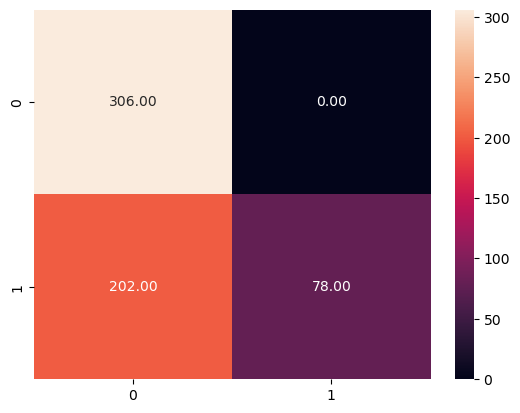

In [44]:
from sklearn.metrics import roc_auc_score

model_basic=SVC(random_state=42,C=10,gamma=10)
model_basic.fit(X_train,y_train)

y_pred_basic=model_basic.predict(X_test)
y_train_pred_basic=model_basic.predict(X_train)

sns.heatmap(confusion_matrix(y_test,y_pred_basic), annot=True, fmt='.2f')

print('Train Accuracy Score:',accuracy_score(y_train,y_train_pred_basic))
print('Test Accuracy Score:',accuracy_score(y_test,y_pred_basic))
print("\nClassification Matrix:\n",classification_report(y_test, y_pred_basic))

model_lists= [['SVC_Basic', accuracy_score(y_train, y_train_pred_basic), accuracy_score(y_test, y_pred_basic), roc_auc_score(y_test, y_pred_basic), precision_score(y_test, y_pred_basic), recall_score(y_test, y_pred_basic),f1_score(y_test, y_pred_basic)]]

### B. Use cross validation techniques.
### C. Apply hyper-parameter tuning techniques to get the best accuracy.

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Hyper-parameters: {'C': 100, 'gamma': 0.001}
Train Accuracy Score: 1.0
Test Accuracy Score: 0.9863481228668942

Classification Matrix:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99       306
           1       0.97      1.00      0.99       280

    accuracy                           0.99       586
   macro avg       0.99      0.99      0.99       586
weighted avg       0.99      0.99      0.99       586



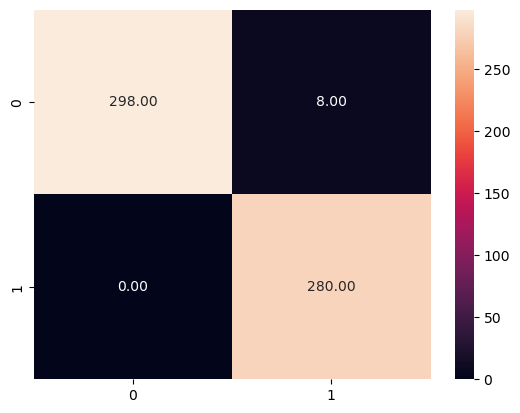

In [45]:
# Using GridSearchCV
grid_param_detail={
    'C':[0.1,1,10,100],
    'gamma':[1,0.1,0.001]
}
grid_search = GridSearchCV(SVC(random_state=42),grid_param_detail, cv=5, refit=True, verbose=1)
grid_search.fit(X_train,y_train)

predicted_model_grid=grid_search.best_estimator_

predicted_model_grid.fit(X_train,y_train)

y_pred_grid = predicted_model_grid.predict(X_test)
y_train_pred_grid = predicted_model_grid.predict(X_train)

sns.heatmap(confusion_matrix(y_test,y_pred_grid), annot=True, fmt='.2f')

print('Hyper-parameters:',grid_search.best_params_)
print('Train Accuracy Score:',accuracy_score(y_train,y_train_pred_grid))
print('Test Accuracy Score:',accuracy_score(y_test,y_pred_grid))
print("\nClassification Matrix:\n",classification_report(y_test, y_pred_grid))

model_lists.append(['SVC_Grid', accuracy_score(y_train, y_train_pred_grid), accuracy_score(y_test, y_pred_grid), roc_auc_score(y_test, y_pred_grid), precision_score(y_test, y_pred_grid), recall_score(y_test, y_pred_grid),f1_score(y_test, y_pred_grid)])

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Hyper-parameters: {'C': 60.24145688620425, 'gamma': 0.056450412719997727}
Train Accuracy Score: 1.0
Test Accuracy Score: 0.947098976109215

Classification Matrix:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95       306
           1       1.00      0.89      0.94       280

    accuracy                           0.95       586
   macro avg       0.95      0.94      0.95       586
weighted avg       0.95      0.95      0.95       586



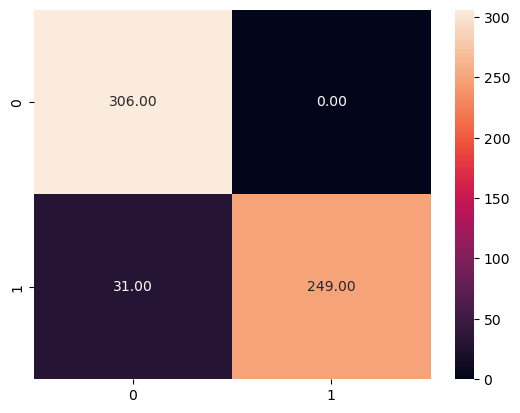

In [46]:
# Using RandomizedSearchCV
random_param_detail={
    'C': stats.uniform(1, 100),
    'gamma': stats.uniform(0.01, 1)
}
randomized_search=RandomizedSearchCV(SVC(random_state=42), random_param_detail, n_iter = 20, cv = 5, random_state = 42, verbose=1)
randomized_search.fit(X_train,y_train)

predicted_model_randomized=randomized_search.best_estimator_

predicted_model_randomized.fit(X_train,y_train)

y_pred_randomized = predicted_model_randomized.predict(X_test)
y_train_pred_randomized = predicted_model_randomized.predict(X_train)

sns.heatmap(confusion_matrix(y_test,y_pred_randomized), annot=True, fmt='.2f')

print('Hyper-parameters:',randomized_search.best_params_)
print('Train Accuracy Score:',accuracy_score(y_train,y_train_pred_randomized))
print('Test Accuracy Score:',accuracy_score(y_test,y_pred_randomized))
print("\nClassification Matrix:\n",classification_report(y_test, y_pred_randomized))

model_lists.append(['SVC_Randomized', accuracy_score(y_train, y_train_pred_randomized), accuracy_score(y_test, y_pred_randomized), roc_auc_score(y_test, y_pred_randomized), precision_score(y_test, y_pred_randomized), recall_score(y_test, y_pred_randomized),f1_score(y_test, y_pred_randomized)])

In [47]:
pd.DataFrame(model_lists,columns=['Model','Train_Accuracy','Test_Accuracy','ROC_AUC Score','Precision','Recall','F1 Score']).sort_values(by='F1 Score', ascending=False)

Model  Train_Accuracy  Test_Accuracy  ROC_AUC Score  Precision  \
1        SVC_Grid             1.0       0.986348       0.986928   0.972222   
2  SVC_Randomized             1.0       0.947099       0.944643   1.000000   
0       SVC_Basic             1.0       0.655290       0.639286   1.000000   

     Recall  F1 Score  
1  1.000000  0.985915  
2  0.889286  0.941399  
0  0.278571  0.435754

Best hyperparameters for SVC has been noted by GridSearchCV, i.e.
{'C': 100, 'gamma': 0.001}

### D. Use any other technique/method which can enhance the model performance.
### E. Display and explain the classification report in detail.

Will use PCA here to remove more unwanted features.

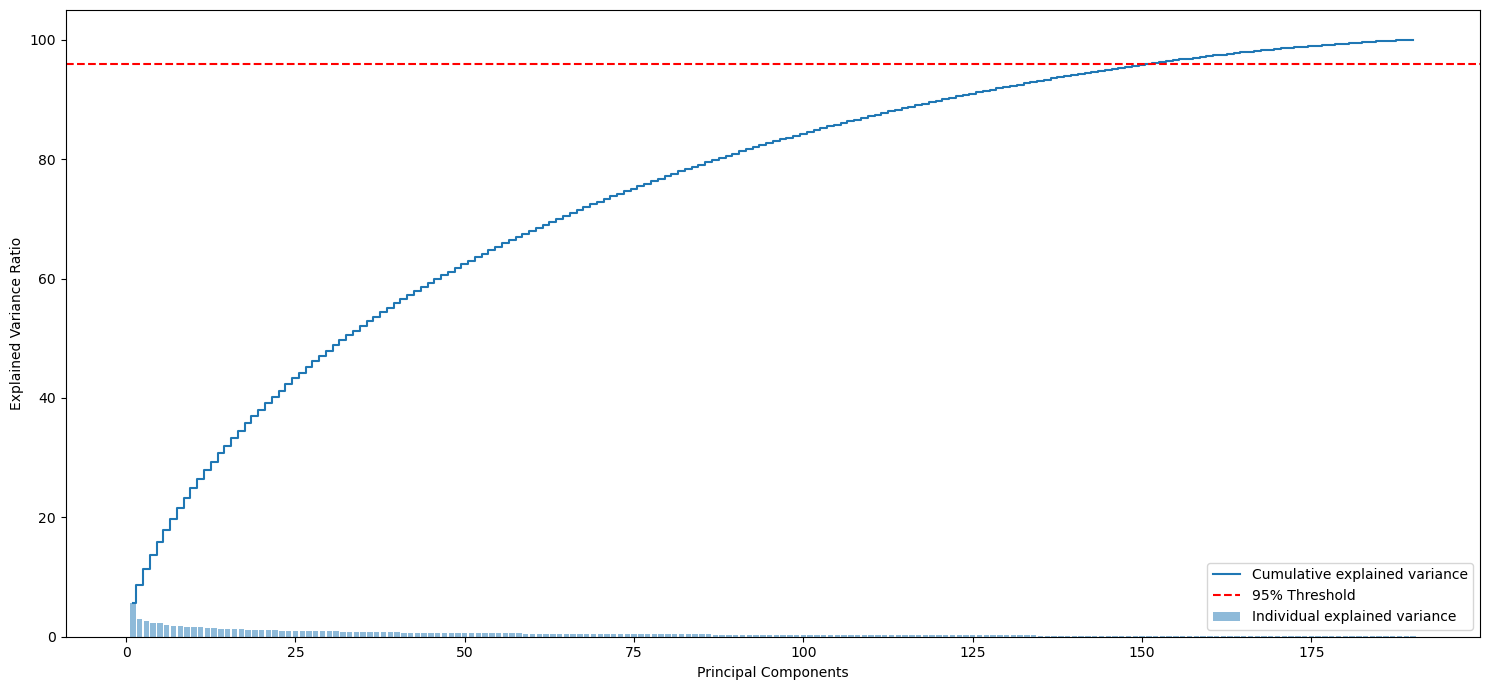

In [48]:
# Step 1 - Create covariance matrix
cov_matrix = np.cov(X.T)

# Step 2- Get eigen values and eigen vector
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

# Step 3- Find variance and cumulative variance by each eigen vector
tot = sum(eig_vals)
var_exp = [( i /tot ) * 100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

# Ploting
plt.figure(figsize=(15 , 7))
plt.bar(range(1, eig_vals.size + 1), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.step(range(1, eig_vals.size + 1), cum_var_exp, where='mid', label = 'Cumulative explained variance')
plt.axhline(96, c='r', linestyle = 'dashed', label = "95% Threshold")
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

Taking 96% of variance gives n_components as 150 for model training.

In [49]:
# PCA with reduced number of components
pca = PCA(n_components=150,random_state=42)
pca.fit(X)

X_pca=pca.fit_transform(X)
X_pca.shape

(2926, 150)

Now we have 150 features, so will be using SVC on this, with tuned hyperparams.

In [50]:
X_pca_train,X_pca_test,y_pca_train,y_pca_test=train_test_split(X_pca, y, test_size=0.20, random_state=42)
X_pca_train.shape, X_pca_test.shape

((2340, 150), (586, 150))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Hyper-parameters: {'C': 100, 'gamma': 0.001}
Train Accuracy Score: 1.0
Test Accuracy Score: 0.9829351535836177

Classification Matrix:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98       306
           1       0.97      1.00      0.98       280

    accuracy                           0.98       586
   macro avg       0.98      0.98      0.98       586
weighted avg       0.98      0.98      0.98       586



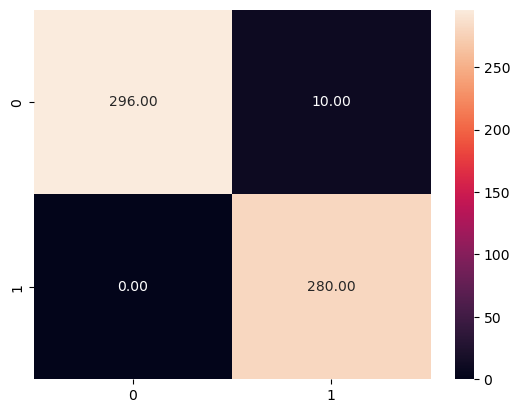

In [51]:
# Using GridSearchCV
grid_param_detail={
    'C':[0.1,1,10,100],
    'gamma':[1,0.1,0.001]
}
pca_grid_search = GridSearchCV(SVC(random_state=42),grid_param_detail, cv=5, refit=True, verbose=1)
pca_grid_search.fit(X_pca_train,y_pca_train)

predicted_model_grid_pca=grid_search.best_estimator_

predicted_model_grid_pca.fit(X_pca_train,y_pca_train)

y_pred_grid_pca = predicted_model_grid.predict(X_pca_test)
y_train_pred_grid_pca = predicted_model_grid.predict(X_pca_train)

sns.heatmap(confusion_matrix(y_pca_test,y_pred_grid_pca), annot=True, fmt='.2f')

print('Hyper-parameters:',grid_search.best_params_)
print('Train Accuracy Score:',accuracy_score(y_pca_train,y_train_pred_grid_pca))
print('Test Accuracy Score:',accuracy_score(y_pca_test,y_pred_grid_pca))
print("\nClassification Matrix:\n",classification_report(y_pca_test, y_pred_grid_pca))

model_lists.append(['SVC_Pca', accuracy_score(y_pca_train, y_train_pred_grid_pca), accuracy_score(y_pca_test, y_pred_grid_pca), roc_auc_score(y_pca_test, y_pred_grid_pca), precision_score(y_pca_test, y_pred_grid_pca), recall_score(y_pca_test, y_pred_grid_pca),f1_score(y_pca_test, y_pred_grid_pca)])

In [52]:
pd.DataFrame(model_lists,columns=['Model','Train_Accuracy','Test_Accuracy','ROC_AUC Score','Precision','Recall','F1 Score']).sort_values(by='F1 Score', ascending=False)

Model  Train_Accuracy  Test_Accuracy  ROC_AUC Score  Precision  \
1        SVC_Grid             1.0       0.986348       0.986928   0.972222   
3         SVC_Pca             1.0       0.982935       0.983660   0.965517   
2  SVC_Randomized             1.0       0.947099       0.944643   1.000000   
0       SVC_Basic             1.0       0.655290       0.639286   1.000000   

     Recall  F1 Score  
1  1.000000  0.985915  
3  1.000000  0.982456  
2  0.889286  0.941399  
0  0.278571  0.435754

After tuning and modelling, we got to know gridSearch and PCA have same F1-score.

### F. Apply the above steps for all possible models that you have learnt so far.

Will be applying gridSearchCV to all learnt technique.

In [53]:
def train_model(x_train_grid, x_test_grid, y_train_grid, y_test_grid):
    """
    train_model function removes features that aren't needed for model training.

    :param x_train_grid: x_train dataset for modelling
    :param x_test_grid: x_test dataset for modelling
    :param y_train_grid: y_train dataset for modelling
    :param y_test_grid: y_test dataset for modelling

    :return list of trained models with metrics
    """

    model_details,param_details,train_model_lists={},{},[]

    model_details={
        'KNN_Classifier': KNeighborsClassifier(),
        'SVM_Classifier': SVC(random_state=42),
        'XGB_Classifier': XGBClassifier(random_state=42),
        'GaussianNB': GaussianNB(),
        'GradientBoosting_Classifier': GradientBoostingClassifier(random_state=42),
        'AdaBoost_Classifier': AdaBoostClassifier(random_state=42),
        'RandomForest_Classifier': RandomForestClassifier(random_state=42),
        'DecisionTree_Classifier': DecisionTreeClassifier(random_state=42),
    }
    param_details={
        'KNN_Classifier': {'n_neighbors': np.arange(1,int(np.sqrt(len(x_train_grid)))).tolist(), 'p': [1,2]},
        'SVM_Classifier': {'C':[0.1,1,10,100],'gamma':[1,0.1,0.001] },
        'XGB_Classifier': {'learning_rate':[0.05,0.10,0.15],'max_depth':[3,4,5],'min_child_weight':[1,3,5],'gamma':[0.1,0.2,0.3],'colsample_bytree':[0.3,0.4,0.5],'n_estimators':[20,40,50]},
        'GaussianNB': {'var_smoothing': np.logspace(0,-9, num=100)},
        'GradientBoosting_Classifier': {'learning_rate': [0.05,0.10,0.15],'min_samples_split': np.linspace(0.1,0.5,3),'min_samples_leaf': np.linspace(0.1,0.5,3),'max_depth':[3,5,8],'max_features':['log2','sqrt'],'subsample':[0.5,1.0],'n_estimators':[20,40,50]},
        'AdaBoost_Classifier': {'n_estimators': [20,40,50,60],'learning_rate': [0.05,0.10,0.15]},
        'RandomForest_Classifier': {'n_estimators': [20,40,50,60],'max_depth' : [4,5,6,7,8],'criterion' :['gini','entropy']},
        'DecisionTree_Classifier': {'ccp_alpha': [0.1,.01,.001],'max_depth': [5, 6, 7, 8, 9],'criterion' :['gini', 'entropy']},
    }

    for key in model_details.keys():
        print("Running GridSearchCV for %s." % key)

        list_grid_search = GridSearchCV(model_details.get(key), param_details.get(key), cv=5, verbose=1, n_jobs=-1, refit=True)
        list_grid_search.fit(x_train_grid,y_train_grid)

        predicted_model=list_grid_search.best_estimator_

        predicted_model.fit(x_train_grid,y_train_grid)

        y_pred = predicted_model.predict(x_test_grid)
        y_train_pred = predicted_model.predict(x_train_grid)

        train_model_lists.append([key, accuracy_score(y_train_grid,y_train_pred), accuracy_score(y_test_grid, y_pred),
            roc_auc_score(y_test_grid,y_pred), precision_score(y_test_grid,y_pred), recall_score(y_test_grid,y_pred), f1_score(y_test_grid,y_pred), predicted_model])

        print("GridSearchCV for %s completed." % key)

    return train_model_lists

basic_model_df=pd.DataFrame(train_model(X_train, X_test, y_train, y_test),columns=['Model_Name','Train_Accuracy','Test_Accuracy','ROC_AUC','Precision','Recall','F1 Score', 'Model']).sort_values(by='F1 Score', ascending=False)

print('\n######### Model Training using PCA #########\n')

pca_model_df=pd.DataFrame(train_model(X_pca_train, X_pca_test, y_pca_train, y_pca_test),columns=['Model_Name','Train_Accuracy','Test_Accuracy','ROC_AUC','Precision','Recall','F1 Score', 'Model']).sort_values(by='F1 Score', ascending=False)

Running GridSearchCV for KNN_Classifier.
Fitting 5 folds for each of 94 candidates, totalling 470 fits
GridSearchCV for KNN_Classifier completed.
Running GridSearchCV for SVM_Classifier.
Fitting 5 folds for each of 12 candidates, totalling 60 fits
GridSearchCV for SVM_Classifier completed.
Running GridSearchCV for XGB_Classifier.
Fitting 5 folds for each of 729 candidates, totalling 3645 fits
GridSearchCV for XGB_Classifier completed.
Running GridSearchCV for GaussianNB.
Fitting 5 folds for each of 100 candidates, totalling 500 fits
GridSearchCV for GaussianNB completed.
Running GridSearchCV for GradientBoosting_Classifier.
Fitting 5 folds for each of 972 candidates, totalling 4860 fits
GridSearchCV for GradientBoosting_Classifier completed.
Running GridSearchCV for AdaBoost_Classifier.
Fitting 5 folds for each of 12 candidates, totalling 60 fits
GridSearchCV for AdaBoost_Classifier completed.
Running GridSearchCV for RandomForest_Classifier.
Fitting 5 folds for each of 40 candidates, 

## 6. Post Training and Conclusion

### A. Display and compare all the models designed with their train and test accuracies.
### B. Select the final best trained model along with your detailed comments for selecting this model.

In [54]:
pca_model_df.Model_Name='pca_'+pca_model_df.Model_Name.astype(str)
pca_model_df

Model_Name  Train_Accuracy  Test_Accuracy   ROC_AUC  \
2               pca_XGB_Classifier        1.000000       0.994881  0.994795   
6      pca_RandomForest_Classifier        0.999573       0.989761  0.989437   
1               pca_SVM_Classifier        1.000000       0.982935  0.983660   
3                   pca_GaussianNB        0.986325       0.982935  0.982446   
4  pca_GradientBoosting_Classifier        0.994872       0.981229  0.980357   
5          pca_AdaBoost_Classifier        0.985897       0.970990  0.971008   
7      pca_DecisionTree_Classifier        0.967949       0.918089  0.918231   
0               pca_KNN_Classifier        1.000000       0.730375  0.741830   

   Precision    Recall  F1 Score  \
2   0.996416  0.992857  0.994633   
6   0.996377  0.982143  0.989209   
1   0.965517  1.000000  0.982456   
3   0.992701  0.971429  0.981949   
4   1.000000  0.960714  0.979964   
5   0.967972  0.971429  0.969697   
7   0.908451  0.921429  0.914894   
0   0.639269  1.000000  0.779944   

                                               Model  
2  XGBClassifier(base_score=0.5, booster='gbtree'...  
6  (DecisionTreeClassifier(criterion='entropy', m...  
1           SVC(C=100, gamma=0.001, random_state=42)  
3      GaussianNB(var_smoothing=0.01519911082952933)  
4  ([DecisionTreeRegressor(criterion='friedman_ms...  
5  (DecisionTreeClassifier(max_depth=1, random_st...  
7  DecisionTreeClassifier(ccp_alpha=0.001, max_de...  
0                KNeighborsClassifier(n_neighbors=2)

In [55]:
basic_model_df

Model_Name  Train_Accuracy  Test_Accuracy   ROC_AUC  \
1               SVM_Classifier        1.000000       0.986348  0.986928   
2               XGB_Classifier        1.000000       0.972696  0.972794   
6      RandomForest_Classifier        0.992735       0.962457  0.963597   
4  GradientBoosting_Classifier        0.967949       0.924915  0.925525   
0               KNN_Classifier        1.000000       0.882253  0.887255   
5          AdaBoost_Classifier        0.917949       0.880546  0.882738   
7      DecisionTree_Classifier        0.946581       0.872014  0.875327   
3                   GaussianNB        0.851282       0.824232  0.822292   

   Precision    Recall  F1 Score  \
1   0.972222  1.000000  0.985915   
2   0.968085  0.975000  0.971530   
6   0.935811  0.989286  0.961806   
4   0.906897  0.939286  0.922807   
0   0.802292  1.000000  0.890302   
5   0.836538  0.932143  0.881757   
7   0.813456  0.950000  0.876442   
3   0.841699  0.778571  0.808905   

                                               Model  
1           SVC(C=100, gamma=0.001, random_state=42)  
2  XGBClassifier(base_score=0.5, booster='gbtree'...  
6  (DecisionTreeClassifier(max_depth=8, max_featu...  
4  ([DecisionTreeRegressor(criterion='friedman_ms...  
0           KNeighborsClassifier(n_neighbors=2, p=1)  
5  (DecisionTreeClassifier(max_depth=1, random_st...  
7  DecisionTreeClassifier(ccp_alpha=0.001, criter...  
3    GaussianNB(var_smoothing=0.0015199110829529332)

In [56]:
predicted_model_list=pd.concat([pca_model_df,basic_model_df],axis=0).sort_values(by='F1 Score',ascending=False)
predicted_model_list

Model_Name  Train_Accuracy  Test_Accuracy   ROC_AUC  \
2               pca_XGB_Classifier        1.000000       0.994881  0.994795   
6      pca_RandomForest_Classifier        0.999573       0.989761  0.989437   
1                   SVM_Classifier        1.000000       0.986348  0.986928   
1               pca_SVM_Classifier        1.000000       0.982935  0.983660   
3                   pca_GaussianNB        0.986325       0.982935  0.982446   
4  pca_GradientBoosting_Classifier        0.994872       0.981229  0.980357   
2                   XGB_Classifier        1.000000       0.972696  0.972794   
5          pca_AdaBoost_Classifier        0.985897       0.970990  0.971008   
6          RandomForest_Classifier        0.992735       0.962457  0.963597   
4      GradientBoosting_Classifier        0.967949       0.924915  0.925525   
7      pca_DecisionTree_Classifier        0.967949       0.918089  0.918231   
0                   KNN_Classifier        1.000000       0.882253  0.887255   
5              AdaBoost_Classifier        0.917949       0.880546  0.882738   
7          DecisionTree_Classifier        0.946581       0.872014  0.875327   
3                       GaussianNB        0.851282       0.824232  0.822292   
0               pca_KNN_Classifier        1.000000       0.730375  0.741830   

   Precision    Recall  F1 Score  \
2   0.996416  0.992857  0.994633   
6   0.996377  0.982143  0.989209   
1   0.972222  1.000000  0.985915   
1   0.965517  1.000000  0.982456   
3   0.992701  0.971429  0.981949   
4   1.000000  0.960714  0.979964   
2   0.968085  0.975000  0.971530   
5   0.967972  0.971429  0.969697   
6   0.935811  0.989286  0.961806   
4   0.906897  0.939286  0.922807   
7   0.908451  0.921429  0.914894   
0   0.802292  1.000000  0.890302   
5   0.836538  0.932143  0.881757   
7   0.813456  0.950000  0.876442   
3   0.841699  0.778571  0.808905   
0   0.639269  1.000000  0.779944   

                                               Model  
2  XGBClassifier(base_score=0.5, booster='gbtree'...  
6  (DecisionTreeClassifier(criterion='entropy', m...  
1           SVC(C=100, gamma=0.001, random_state=42)  
1           SVC(C=100, gamma=0.001, random_state=42)  
3      GaussianNB(var_smoothing=0.01519911082952933)  
4  ([DecisionTreeRegressor(criterion='friedman_ms...  
2  XGBClassifier(base_score=0.5, booster='gbtree'...  
5  (DecisionTreeClassifier(max_depth=1, random_st...  
6  (DecisionTreeClassifier(max_depth=8, max_featu...  
4  ([DecisionTreeRegressor(criterion='friedman_ms...  
7  DecisionTreeClassifier(ccp_alpha=0.001, max_de...  
0           KNeighborsClassifier(n_neighbors=2, p=1)  
5  (DecisionTreeClassifier(max_depth=1, random_st...  
7  DecisionTreeClassifier(ccp_alpha=0.001, criter...  
3    GaussianNB(var_smoothing=0.0015199110829529332)  
0                KNeighborsClassifier(n_neighbors=2)

XGBClassifier trained with PCA features has given highest F1 Score, so we can use this model for our future usage.

### C. Pickle the selected model for future use.

In [57]:
model=predicted_model_list.head(1).Model.values[0]

# create an iterator object with write permission - model.pkl
with open('model_pkl', 'wb') as files:
    pickle.dump(model, files)

with open('model_pkl' , 'rb') as f:
    pickle_model = pickle.load(f)
print(pickle_model)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.1, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)


XGBClassifier has been saved for future usage.

### D. Write your conclusion on the results.

Original data have 592 features with 1 as target value named as 'Pass/Fail' which contains values as '–1' corresponds to a pass and '1' corresponds to a fail, another feature is 'Time' which have dateTime for that specific test point and other features are some measurement points.
This dataset contains year 2008 measurements.
In this dataset there were many missing values with some irrelevant measurement recordings for some features.

This dataset has been analysed and have performed different techniques for imputation of missing entries, outliers removal and irrelevant features deletion.
As this dataset contains multi-collinearity and strong correlation, so correlation, VIF and PCA has been used to remove these features, so provided dataset can be used of modelling.
For modelling, converted target values as -1 to 0 as 'PASS' and 1 'FAIL' as it as.
Once all pre-requisites has been performed, dataset has gone through many models and the best model has been pickle for futuristic use.